#Reconhecimento de Faces

### Preparando ambiente

In [1]:
!pip install --upgrade face_recognition
!pip install --upgrade opencv-python

Requirement already up-to-date: face_recognition in /usr/local/lib/python3.6/dist-packages (1.2.3)
Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.1.0.25)


### Importando faces conhecidas

In [2]:
!wget -O humberto.jpg 'https://scontent-gru2-1.xx.fbcdn.net/v/t1.0-1/p320x320/1513659_10206592473919761_8633063549213585257_n.jpg?_nc_cat=106&_nc_ht=scontent-gru2-1.xx&oh=04128ef9a1a7e7bc6a822906811f8208&oe=5D61A506'
!wget -O bruno.jpg 'https://media.licdn.com/dms/image/C4E03AQHgVX89QYbDQw/profile-displayphoto-shrink_800_800/0?e=1562803200&v=beta&t=WdutsbgUGFWMim_Nx4IxUczb4U94fvbfkHWYu_M-38M'
!ls -la

--2019-05-10 19:50:03--  https://scontent-gru2-1.xx.fbcdn.net/v/t1.0-1/p320x320/1513659_10206592473919761_8633063549213585257_n.jpg?_nc_cat=106&_nc_ht=scontent-gru2-1.xx&oh=04128ef9a1a7e7bc6a822906811f8208&oe=5D61A506
Resolving scontent-gru2-1.xx.fbcdn.net (scontent-gru2-1.xx.fbcdn.net)... 31.13.85.4, 2a03:2880:f005:8:face:b00c:0:1
Connecting to scontent-gru2-1.xx.fbcdn.net (scontent-gru2-1.xx.fbcdn.net)|31.13.85.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15856 (15K) [image/jpeg]
Saving to: ‘humberto.jpg’

humberto.jpg        100%[===================>]  15.48K  90.0KB/s    in 0.2s    

2019-05-10 19:50:04 (90.0 KB/s) - ‘humberto.jpg’ saved [15856/15856]

total 32
drwxr-xr-x 1 root root  4096 May 10 19:50 .
drwxr-xr-x 1 root root  4096 May 10 19:46 ..
drwxr-xr-x 1 root root  4096 May  9 16:05 .config
-rw-r--r-- 1 root root 15856 Apr 22  2015 humberto.jpg
drwxr-xr-x 1 root root  4096 May  8 16:22 sample_data


### Importando bibliotecas e definindo funções

In [0]:
import face_recognition
import cv2
import numpy as np

from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import urllib

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  resp = urllib.request.urlopen(data)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

### Carregando imagens para serem reconhecidas

In [0]:
# Load a sample picture and learn how to recognize it.
humberto_image = face_recognition.load_image_file("humberto.jpg")
humberto_face_encoding = face_recognition.face_encodings(humberto_image)[0]

bruno_image = face_recognition.load_image_file("bruno.jpg")
bruno_face_encoding = face_recognition.face_encodings(bruno_image)[0]

# Create arrays of known face encodings and their names
known_face_encodings = [
    humberto_face_encoding,
    bruno_face_encoding
]
known_face_names = [
    "Humberto",
    "Bruno"
]

### Reconhecendo faces

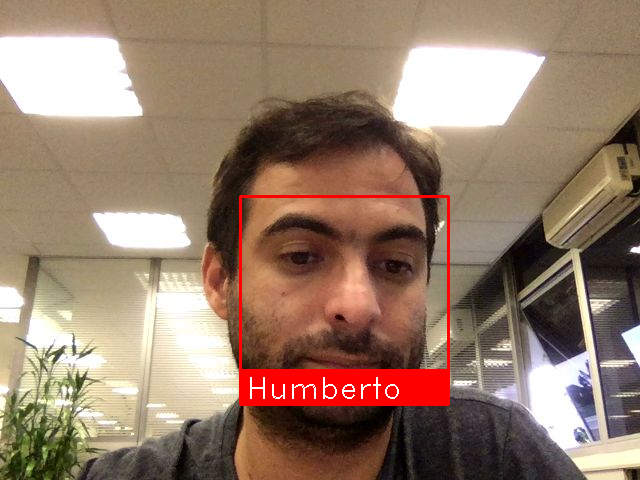

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [5]:
# Inicializa as variáveis de resultados
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
first = True

filename = 'result.jpg'
scale = 4

while True:
    # Captura um simples frame (bate uma foto)
    frame = take_photo()

    # Reduz a dimensão do frame para 1/4 para acelerar o processo de reconhecimento
    small_frame = cv2.resize(frame, (0, 0), fx=1/scale, fy=1/scale)

    # Converte o frame de BGR (OpenCV usa) para RGB (face_recognition usa)
    rgb_small_frame = small_frame[:, :, ::-1]

    # Only process every other frame of video to save time
    if process_this_frame:
        # Procura todas as faces no frame atual
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # Procura a face na lista de faces conhecidas
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Dentre as escolhidas, encontrar a face com a menor distância
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

    process_this_frame = not process_this_frame

    # Exibe os resultados
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # Rescala a image para o tamanho original
        top *= scale
        right *= scale
        bottom *= scale
        left *= scale

        # Desenha um retângulo em torno da face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Desenha um rótulo para a face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
        
    clear_output()
    # Exibindo o resultado
    cv2_imshow(frame)
